# Opens fits files and displays info, works with csvs to produce location plots etc.

In [1]:
# Call the relevant python packages

%matplotlib notebook

import math
import random
import numpy as np
import pandas as pd
import glob, os
import nway

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from astropy import units as u
from astropy.io import ascii, fits
from astropy.table import join, hstack, Table, Column, vstack
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord

# Set colour palette & plot layouts
import seaborn as sns     #; sns.set()
sns.set_context("paper")   # "paper", "notebook", "talk", "poster"

# Fits Files

In [2]:
# Open a fits file and display info
filein = 'single_radii/all_36_45_matched.fits'
fits_im = fits.open(filein)
fits_im.info()

# Print data
data = fits_im[1].data
print(len(data))
print(data[0:2])

Filename: single_radii/all_36_45_matched.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1  NWAYMATCH     1 BinTableHDU    183   8887R x 87C   [7A, D, D, D, D, 7A, D, D, D, D, D, D, K, D, D, D, D, D, K, K, D, D, 7A, D, D, D, D, D, D, K, D, D, D, D, D, K, K, D, D, 7A, D, D, D, D, 7A, D, D, D, D, D, D, K, D, D, D, D, D, K, K, D, D, 7A, D, D, D, D, D, D, K, D, D, D, D, D, K, K, D, D, E, E, I, E, E, E, E, E, I]   
8887
[('1', 10.60573757, 40.8624973, 17.52850491, 0.0556, '1646', 10.60563612, 40.86244107, 17.95750491, 0.0519, 0.3424452, 0.3424452, 2, 11.708483, 0.94459933, 0.94459933, 0.94459933, 1., 1, 2, 10.60568684, 40.86246919, '4044', 10.60565694, 40.86250859, 17.45050491, 0.0731, 0.16356307, 0.16356307, 2, 11.954174, 0.9681216, 0.9681216, 0.9681216, 1., 1, 3, 10.60567688, 40.86248232, '-99', -99.        , -99.        , -99.        , -9.90e+01, '-99', -99.        , -99.        , -99.        , -99.    , -99.        

In [3]:
# Print fits header fields
hdr = fits_im[1].header
hdr

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  650 / length of dimension 1                          
NAXIS2  =                 8887 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   87 / number of table fields                         
TTYPE1  = 'S1_1_3_4_ID'                                                         
TFORM1  = '7A      '                                                            
TTYPE2  = 'S1_1_3_4_S1_1_3_S1_F1_RA'                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'S1_1_3_4_S1_1_3_S

# Convert fits to text

In [4]:
text_file = open('single_radii/all_36_45_text.txt','w')
for i in range(8,len(hdr)-1,2):
    name = str(hdr[i])+' '
    print(name)
    text_file.write(name)
    
for i in range(len(data)):
    line = '\n'+str(data[i])[1:len(str(data[i]))-1]+' '
    text_file.write(line)
    
text_file.close()

S1_1_3_4_ID 
S1_1_3_4_S1_1_3_S1_F1_RA 
S1_1_3_4_S1_1_3_S1_F1_DEC 
S1_1_3_4_S1_1_3_S1_F1_MAG1_1 
S1_1_3_4_S1_1_3_S1_F1_ERR1_1 
S1_1_3_4_S1_1_3_S1_F3_ID 
S1_1_3_4_S1_1_3_S1_F3_RA 
S1_1_3_4_S1_1_3_S1_F3_DEC 
S1_1_3_4_S1_1_3_S1_F3_MAG1_3 
S1_1_3_4_S1_1_3_S1_F3_ERR1_3 
S1_1_3_4_S1_1_3_Separation_S1_F3_S1_F1 
S1_1_3_4_S1_1_3_Separation_max 
S1_1_3_4_S1_1_3_ncat 
S1_1_3_4_S1_1_3_dist_bayesfactor 
S1_1_3_4_S1_1_3_dist_post 
S1_1_3_4_S1_1_3_p_single 
S1_1_3_4_S1_1_3_p_any 
S1_1_3_4_S1_1_3_p_i 
S1_1_3_4_S1_1_3_match_flag 
S1_1_3_4_S1_1_3_asn 
S1_1_3_4_S1_1_3_RA 
S1_1_3_4_S1_1_3_DEC 
S1_1_3_4_S1_F4_ID 
S1_1_3_4_S1_F4_RA 
S1_1_3_4_S1_F4_DEC 
S1_1_3_4_S1_F4_MAG1_4 
S1_1_3_4_S1_F4_ERR1_4 
S1_1_3_4_Separation_S1_F4_S1_1_3 
S1_1_3_4_Separation_max 
S1_1_3_4_ncat 
S1_1_3_4_dist_bayesfactor 
S1_1_3_4_dist_post 
S1_1_3_4_p_single 
S1_1_3_4_p_any 
S1_1_3_4_p_i 
S1_1_3_4_match_flag 
S1_1_3_4_asn 
S1_1_3_4_RA 
S1_1_3_4_DEC 
S2_1_3_4_ID 
S2_1_3_4_S2_1_3_S2_F1_RA 
S2_1_3_4_S2_1_3_S2_F1_DEC 
S2_1_3_4_S2_1_3_S2

# Match visualisation (ignores sky curvature)

0.24520263593797173 arcsec
5.555555555555556e-05 deg


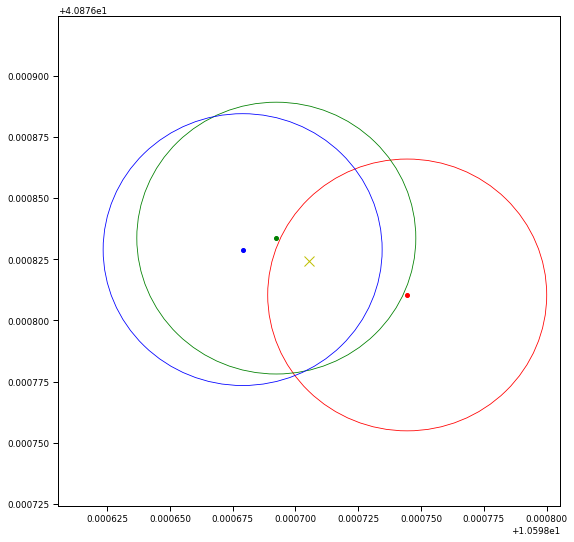

In [6]:
%matplotlib inline
plt.figure(figsize=(9,9))
x1,y1 = 10.5987445,40.87681039
x2,y2 = 10.59869237,40.87683363
x3,y3 = 10.59867896,40.87682893
sep13 = math.sqrt((x3-x1)**2 + (y3-y1)**2) * u.degree
sep13 = sep13.to(u.arcsec)
print(sep13)
plt.plot(x1,y1,'ro',ms=4)
plt.plot(x2,y2,'go',ms=4)
plt.plot(x3,y3,'bo',ms=4)
stretch = 0.0001
x_mean = (x1+x2+x3)/3
y_mean = (y1+y2+y3)/3
plt.plot(x_mean,y_mean,'yx',ms=10)
plt.xlim(x_mean-stretch,x_mean+stretch)
plt.ylim(y_mean-stretch,y_mean+stretch)

ax = plt.gca()
radius = 0.2*u.arcsec
radius = radius.to(u.deg)
print(radius)
circle1 = plt.Circle((x1,y1), radius.value, color='red', fill=False) #max allowed radius
circle2 = plt.Circle((x2,y2), radius.value, color='green', fill=False) #actual separation
circle3 = plt.Circle((x3,y3), radius.value, color='blue', fill=False) #actual separation

ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)

# Catalogue Operations

In [10]:
# Define function to produce 3D graph
# NB: ONLY WORKS FOR CSV FILES!!
def graph(file,filtr,epoch,var):
    # Setting up figure
    plt.rc('font', family='sans-serif')
    #plt.rc("xtick", labelsize=8)
    #plt.rc("ytick", labelsize=8)
    plt.rc("axes", labelsize=10)
    plt.rc("legend", fontsize=11)
    plt.figure(figsize=(6,6))
    #ax = plt.gca()                        # Sets up active plot region
    ax = plt.axes(projection='3d')
    
    # Make the actual plot
    data = ascii.read(file, data_start=1)
    ax.plot3D(data['RA'], data['DEC'], data[var], '.', color='black', ms=0.5, label="M32 All")
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.set_zlabel(var)
    #plt.xlabel('RA', size=18)
    #plt.ylabel('DEC', size=18)
    #plt.zlabel(var, size=18)
    #plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    #plt.title(filtr+'-'+epoch,fontsize=18)
    
    # Plot a box
    #x1,y1=[maxRA.value,minRA.value],[minDec.value,minDec.value]
    #x2,y2=[minRA.value,minRA.value],[minDec.value,maxDec.value]
    #x3,y3=[minRA.value,maxRA.value],[maxDec.value,maxDec.value]
    #x4,y4=[maxRA.value,maxRA.value],[maxDec.value,minDec.value]
    #plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='black')
    
    #plt.savefig("blah.pdf", bbox_inches='tight')
    #plt.tight_layout()
    #plt.show()
    #plt.close()

<IPython.core.display.Javascript object>


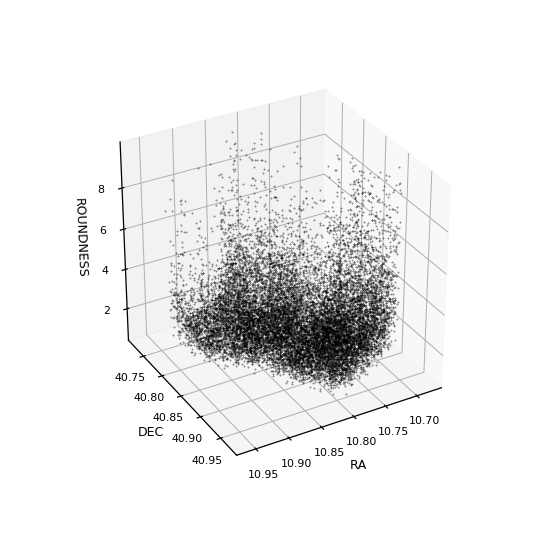

In [11]:
graph('MAG_S1_0.csv','36','background','ROUNDNESS')
#graph(csvfile,'36','background','SHARPNESS')
#graph(csvfile,'36','background','MAG1')
#graph(csvfile,'36','background','ERR1')

In [13]:
# Define function to produce location plot
def loc_plot(file,file1,filtr,epoch):
    %matplotlib inline
    # Setting up figure
    plt.rc('font', family='sans-serif')
    plt.rc("xtick", labelsize=14)
    plt.rc("ytick", labelsize=14)
    plt.rc("axes", labelsize=14)
    plt.rc("legend", fontsize=11)
    plt.figure(figsize=(9,9))
    ax = plt.gca()                        # Sets up active plot region
    
    # Make the actual plot
    data = ascii.read(file, data_start=1)
    index = random.randint(1,len(data))
    data1 = ascii.read(file1, data_start=1)
    #width = 5 * u.arcsec
    #width = width.to(u.degree)
    plt.plot(data['mean_RA'], data['mean_DEC'], '.', color='red', ms=4, label="M32 Primary")
    plt.plot(data1['mean_RA'], data1['mean_DEC'], '.', color='white', ms=4, label="M32 Secondary") 
    plt.xlabel('Right Ascension (deg)', size=18)
    plt.ylabel('Declination (deg)', size=18)
    #plt.xlim(data['RA'][index]-width.value,data['RA'][index]+width.value)
    #plt.ylim(data['DEC'][index]-width.value,data['DEC'][index]+width.value)
    plt.legend(loc="upper left",frameon=False, scatterpoints=1, numpoints=1, markerscale=3.)
    plt.title(filtr+'-'+epoch,fontsize=18)
    #radius = 0.2 * u.arcsec
    #radius = radius.to(u.degree)
    #circle1 = plt.Circle((data['RA'][index],data['DEC'][index]), radius.value, color='blue', fill=False)
    #ax.add_artist(circle1)
    
    # Plot a box
    #x1,y1=[maxRA.value,minRA.value],[minDec.value,minDec.value]
    #x2,y2=[minRA.value,minRA.value],[minDec.value,maxDec.value]
    #x3,y3=[minRA.value,maxRA.value],[maxDec.value,maxDec.value]
    #x4,y4=[maxRA.value,maxRA.value],[maxDec.value,minDec.value]
    #plt.plot(x1,y1,x2,y2,x3,y3,x4,y4,color='black')
    
    plt.savefig("prim_sec_cats_difference.pdf", bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close()

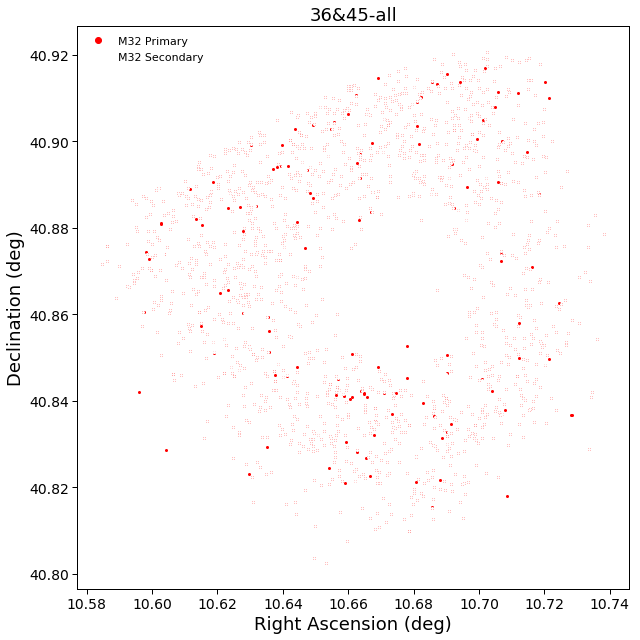

In [14]:
# Show location plot of background 36 field
loc_plot('final_cats/1point5_rmax_&_point2_pos.csv','final_cats/1_rmax_&_point2_pos.csv','36&45','all')

In [27]:
#print column names
data_36.colnames

['RA', 'DEC', 'ROUNDESS', 'SHARPNESS', 'MAG1', 'ERR1']

In [5]:
# Use for single filter 1+3

file = 'single_radii/45_1_3_text.csv'
csv_data = ascii.read(file, header_start=0)
csv_data.colnames   # Get the column names
print("Number of rows:",len(csv_data))

# Cull all those matches with a match flag !=1    
good_match_idx = np.where(csv_data['match_flag']==1)
good_data = csv_data[good_match_idx]
print("Amount of good match data:",len(good_data))

# See how many remain compared to original combined [3.6]/[4.5]
match_1_pct = len(good_data)*100/len(csv_data)
print("Percentage of good match data: ",match_1_pct,"%")

# Set up columns for association number and mean coordinates
good_data['asn']=0
good_data['RA']=0.0
good_data['DEC']=0.0

for i in range(len(good_data)):
    associations = 1
    RA = good_data['S2_F1_RA'][i]
    DEC = good_data['S2_F1_DEC'][i]
    
    # -99 means no match, so ignore these coordinates
    if good_data['S2_F3_RA'][i]!=-99:
        RA = RA + good_data['S2_F3_RA'][i]
        DEC = DEC + good_data['S2_F3_DEC'][i]
        associations = associations + 1
    #if good_data['S2_F4_RA'][i]!=-99:
    #    RA = RA + good_data['S2_F4_RA'][i]
    #    DEC = DEC + good_data['S2_F4_DEC'][i]
    #    associations = associations + 1
        
    good_data['asn'][i]=associations
    good_data['RA'][i]=RA/associations
    good_data['DEC'][i]=DEC/associations
    
#asn_3_idx = np.where(good_data['asn']==3)
#print("3 out of 3 associations:",len(asn_3_idx[0]))
asn_2_idx = np.where(good_data['asn']==2)
print("2 out of 2 associations",len(asn_2_idx[0]))
asn_1_idx = np.where(good_data['asn']==1)
print("1 out of 2 associations",len(asn_1_idx[0]))

# Cull those with no counterparts (no variability)
#idx_asn = np.where(good_data['asn']!=1)
#print("This number should be the sum of the two above:",len(idx_asn[0]))
#good_asn_data = good_data[idx_asn]
## See how many remain compared to original combined [3.6]/[4.5]
#good_asn_pct = 100*len(good_asn_data)/len(csv_data)
#print("Amount of good match data with counterpart(s): ",good_asn_pct,"%")

# Rename 1st ID as ID
good_data.rename_column('S2_F1_ID', 'ID')

# Remove first and last characters of ID number ('')
col_change_list = ['ID','S2_F3_ID']
for i in range(len(good_data)):
    for j in range(len(col_change_list)):
        good_data[col_change_list[j]][i]=int(str(good_data[col_change_list[j]][i])[1:len(str(good_data[col_change_list[j]][i]))-1])


good_data.write('single_radii/45_1_3_good_mean_fits.fits', overwrite=True)

# Display a small portion of the data to check formatting
good_data[0:3].show_in_notebook()

Number of rows: 18088
Amount of good match data: 11795
Percentage of good match data:  65.20897832817337 %
2 out of 2 associations 5915
1 out of 2 associations 5880


idx,ID,S2_F1_RA,S2_F1_DEC,S2_F1_MAG2_1,S2_F1_ERR2_1,S2_F3_ID,S2_F3_RA,S2_F3_DEC,S2_F3_MAG2_3,S2_F3_ERR2_3,Separation_S2_F3_S2_F1,Separation_max,ncat,dist_bayesfactor,dist_post,p_single,p_any,p_i,match_flag,asn,RA,DEC
0,1,10.52251505,40.95751873,17.18055224,0.0829,-99,-99.0,-99.0,-99.0,-99.0,nan,0.0,1,0.0,1.0,1.0,0.0,0.0,1,1,10.52251505,40.95751873
1,4,10.53570645,40.95238343,16.20155224,0.039,-99,-99.0,-99.0,-99.0,-99.0,nan,0.0,1,0.0,1.0,1.0,0.0,0.0,1,1,10.53570645,40.95238343
2,5,10.52813958,40.97739517,15.76255224,0.037,-99,-99.0,-99.0,-99.0,-99.0,nan,0.0,1,0.0,1.0,1.0,0.0,0.0,1,1,10.52813958,40.97739517


In [5]:
# Use for single filter (1+3) + 4

file = 'single_radii/45_1_3_4_text.csv'
csv_data = ascii.read(file, header_start=0)
csv_data.colnames   # Get the column names
print("Number of rows:",len(csv_data))

# Cull all those matches with a match flag !=1    
good_match_idx = np.where(csv_data['match_flag']==1)
good_data = csv_data[good_match_idx]
print("Amount of good match data:",len(good_data))

# See how many remain compared to original combined [3.6]/[4.5]
match_1_pct = len(good_data)*100/len(csv_data)
print("Percentage of good match data: ",match_1_pct,"%")

# Set up columns for association number and mean coordinates
good_data['asn']=0
good_data['RA']=0.0
good_data['DEC']=0.0

for i in range(len(good_data)):
    associations = 1
    RA = good_data['S2_1_3_S2_F1_RA'][i]
    DEC = good_data['S2_1_3_S2_F1_DEC'][i]
    
    # -99 means no match, so ignore these coordinates
    if good_data['S2_1_3_S2_F3_RA'][i]!=-99:
        RA = RA + good_data['S2_1_3_S2_F3_RA'][i]
        DEC = DEC + good_data['S2_1_3_S2_F3_DEC'][i]
        associations = associations + 1
    if good_data['S2_F4_RA'][i]!=-99:
        RA = RA + good_data['S2_F4_RA'][i]
        DEC = DEC + good_data['S2_F4_DEC'][i]
        associations = associations + 1
        
    good_data['asn'][i]=associations
    good_data['RA'][i]=RA/associations
    good_data['DEC'][i]=DEC/associations
    
asn_3_idx = np.where(good_data['asn']==3)
print("3 out of 3 associations:",len(asn_3_idx[0]))
asn_2_idx = np.where(good_data['asn']==2)
print("2 out of 2 associations",len(asn_2_idx[0]))
asn_1_idx = np.where(good_data['asn']==1)
print("1 out of 2 associations",len(asn_1_idx[0]))

# Cull those with no counterparts (no variability)
idx_asn = np.where(good_data['asn']!=1)
print("This number should be the sum of the two above:",len(idx_asn[0]))
good_asn_data = good_data[idx_asn]
# See how many remain compared to original combined [3.6]/[4.5]
good_asn_pct = 100*len(good_asn_data)/len(csv_data)
print("Amount of good match data with counterpart(s): ",good_asn_pct,"%")

# Rename 1st ID as ID
good_asn_data.rename_column('S2_1_3_ID', 'ID')

# Remove first and last characters of ID number ('')
col_change_list = ['ID','S2_1_3_S2_F3_ID','S2_F4_ID']
for i in range(len(good_asn_data)):
    for j in range(len(col_change_list)):
        good_asn_data[col_change_list[j]][i]=int(str(good_asn_data[col_change_list[j]][i])[1:len(str(good_asn_data[col_change_list[j]][i]))-1])

#good_asn_data.write('all_good_45_mean_csv.csv', overwrite=True)
good_asn_data.write('single_radii/45_1_3_4_good_mean_fits.fits', overwrite=True)

# Display a small portion of the data to check formatting
good_asn_data[0:3].show_in_notebook()

Number of rows: 18674
Amount of good match data: 11795
Percentage of good match data:  63.16268608760844 %
3 out of 3 associations: 4460
2 out of 2 associations 3461
1 out of 2 associations 3874
This number should be the sum of the two above: 7921
Amount of good match data with counterpart(s):  42.41726464603192 %


idx,ID,S2_1_3_S2_F1_RA,S2_1_3_S2_F1_DEC,S2_1_3_S2_F1_MAG2_1,S2_1_3_S2_F1_ERR2_1,S2_1_3_S2_F3_ID,S2_1_3_S2_F3_RA,S2_1_3_S2_F3_DEC,S2_1_3_S2_F3_MAG2_3,S2_1_3_S2_F3_ERR2_3,S2_1_3_Separation_S2_F3_S2_F1,S2_1_3_Separation_max,S2_1_3_ncat,S2_1_3_dist_bayesfactor,S2_1_3_dist_post,S2_1_3_p_single,S2_1_3_p_any,S2_1_3_p_i,S2_1_3_match_flag,S2_1_3_asn,S2_1_3_RA,S2_1_3_DEC,S2_F4_ID,S2_F4_RA,S2_F4_DEC,S2_F4_MAG2_4,S2_F4_ERR2_4,Separation_S2_F4_S2_1_3,Separation_max,ncat,dist_bayesfactor,dist_post,p_single,p_any,p_i,match_flag,asn,RA,DEC
0,7,10.56976461,40.97518359,17.90855224,0.1155,12471,10.56933146,40.97542008,18.47955224,0.1275,1.4528701,1.4528701,2,6.2972746,6.15e-05,6.15e-05,6.15e-05,1.0,1,2,10.569548035,40.975301835,1154,10.56952853,40.97525634,17.52755224,0.0877,0.17214829,0.17214829,2,11.946351,0.9647347,0.9647347,0.9647347,1.0,1,3,10.569541533333334,40.975286669999996
1,8,10.58090827,40.97796036,17.52155224,0.054,5734,10.58089803,40.97796894,17.29655224,0.069,0.041576777,0.041576777,2,12.022099,0.97026247,0.97026247,0.97026247,1.0,1,2,10.58090315,40.97796465,-99,-99.0,-99.0,-99.0,-99.0,nan,0.0,1,0.0,1.0,1.0,0.0,0.0,1,2,10.580903150000001,40.97796465
2,9,10.58166921,40.98019078,17.22255224,0.0852,65,10.58166703,40.98012583,17.22955224,0.086,0.23389505,0.23389505,2,11.878297,0.9590677,0.9590677,0.9590677,1.0,1,2,10.58166812,40.980158305,423,10.58165598,40.98009214,17.18155224,0.0813,0.24046823,0.24046823,2,11.869834,0.95822424,0.95822424,0.95822424,1.0,1,3,10.581664073333334,40.98013625


In [5]:
# Use for joining filters

file = 'single_radii/all_36_45_text.csv'
csv_data = ascii.read(file, header_start=0)
csv_data.colnames   # Get the column names
print("Number of rows:",len(csv_data))

# Cull all those matches with a match flag !=1    
good_match_idx = np.where(csv_data['match_flag']==1)
good_data = csv_data[good_match_idx]
print("Amount of good match data:",len(good_data))

# See how many remain compared to original combined [3.6]/[4.5]
match_1_pct = len(good_data)*100/len(csv_data)
print("Percentage of good match data: ",match_1_pct,"%")

# Set up columns for association number and mean coordinates
good_data['total_asn']=0
good_data['mean_RA']=0.0
good_data['mean_DEC']=0.0

for i in range(len(good_data)):
    #associations = 1
    counter = 1
    associations = good_data['S1_1_3_4_asn'][i]
    RA = good_data['S1_1_3_4_RA'][i]
    DEC = good_data['S1_1_3_4_DEC'][i]
    
    # -99 means no match, so ignore these coordinates
    if good_data['S2_1_3_4_RA'][i]!=-99:
        RA = RA + good_data['S2_1_3_4_RA'][i]
        DEC = DEC + good_data['S2_1_3_4_DEC'][i]
        #associations = associations + 1
        counter = counter + 1
        associations = associations + good_data['S2_1_3_4_asn'][i]
    #if good_data['S1_F4_RA'][i]!=-99:
    #    RA = RA + good_data['S1_F4_RA'][i]
    #    DEC = DEC + good_data['S1_F4_DEC'][i]
    #    associations = associations + 1
        
    good_data['total_asn'][i]=associations
    #good_data['mean_RA'][i]=RA/associations
    good_data['mean_RA'][i]=RA/counter
    #good_data['mean_DEC'][i]=DEC/associations
    good_data['mean_DEC'][i]=DEC/counter
    
#asn_3_idx = np.where(good_data['asn']==3)
#print("3 out of 3 associations:",len(asn_3_idx[0]))
#asn_2_idx = np.where(good_data['asn']==2)
#print("2 out of 2/3 associations",len(asn_2_idx[0]))
#asn_1_idx = np.where(good_data['asn']==1)
#print("1 out of 2/3 associations",len(asn_1_idx[0]))

asn_6_idx = np.where(good_data['total_asn']==6)
print("6 out of 6 associations:",len(asn_6_idx[0]))
asn_5_idx = np.where(good_data['total_asn']==5)
print("5 out of 6 associations:",len(asn_5_idx[0]))
asn_4_idx = np.where(good_data['total_asn']==4)
print("4 out of 6 associations:",len(asn_4_idx[0]))

# Cull those with no 45 counterpart
idx_asn = np.where(good_data['S2_1_3_4_RA']!=-99)
print("Those with a 45 counterpart:",len(idx_asn[0]))
good_asn_data = good_data[idx_asn]
# See how many remain compared to original combined [3.6]/[4.5]
good_asn_pct = 100*len(good_asn_data)/len(csv_data)
print("Amount of good match data with counterpart(s): ",good_asn_pct,"%")

# Rename 1st ID as ID for matching to another catalogue
#good_asn_data.rename_column('S1_1_3_ID', 'ID')

# Remove first and last characters of ID number ('')
col_change_list = ['S1_1_3_4_ID','S1_1_3_4_S1_1_3_S1_F3_ID','S1_1_3_4_S1_F4_ID',
                   'S2_1_3_4_ID','S2_1_3_4_S2_1_3_S2_F3_ID','S2_1_3_4_S2_F4_ID']
for i in range(len(good_asn_data)):
    for j in range(len(col_change_list)):
        good_asn_data[col_change_list[j]][i]=int(str(good_asn_data[col_change_list[j]][i])[1:len(str(good_asn_data[col_change_list[j]][i]))-1])

# Rename (ID, RA, Dec)1 as (ID, RA, Dec) for matching to another catalogue
#good_data.rename_column('S2_F1_ID', 'ID')
#good_data.rename_column('S2_F1_RA', 'RA')
#good_data.rename_column('S2_F1_DEC', 'DEC')

good_asn_data.write('single_radii/final_cat_csv.csv', overwrite=True)
#good_asn_data.write('single_radii/36_1_3_4_good_mean_fits.fits', overwrite=True)

# Display a small portion of the data to check formatting
good_asn_data[0:8].show_in_notebook()

Number of rows: 8887
Amount of good match data: 7260
Percentage of good match data:  81.69235962642061 %
6 out of 6 associations: 610
5 out of 6 associations: 661
4 out of 6 associations: 253
Those with a 45 counterpart: 1524
Amount of good match data with counterpart(s):  17.148644086868458 %


idx,S1_1_3_4_ID,S1_1_3_4_S1_1_3_S1_F1_RA,S1_1_3_4_S1_1_3_S1_F1_DEC,S1_1_3_4_S1_1_3_S1_F1_MAG1_1,S1_1_3_4_S1_1_3_S1_F1_ERR1_1,S1_1_3_4_S1_1_3_S1_F3_ID,S1_1_3_4_S1_1_3_S1_F3_RA,S1_1_3_4_S1_1_3_S1_F3_DEC,S1_1_3_4_S1_1_3_S1_F3_MAG1_3,S1_1_3_4_S1_1_3_S1_F3_ERR1_3,S1_1_3_4_S1_1_3_Separation_S1_F3_S1_F1,S1_1_3_4_S1_1_3_Separation_max,S1_1_3_4_S1_1_3_ncat,S1_1_3_4_S1_1_3_dist_bayesfactor,S1_1_3_4_S1_1_3_dist_post,S1_1_3_4_S1_1_3_p_single,S1_1_3_4_S1_1_3_p_any,S1_1_3_4_S1_1_3_p_i,S1_1_3_4_S1_1_3_match_flag,S1_1_3_4_S1_1_3_asn,S1_1_3_4_S1_1_3_RA,S1_1_3_4_S1_1_3_DEC,S1_1_3_4_S1_F4_ID,S1_1_3_4_S1_F4_RA,S1_1_3_4_S1_F4_DEC,S1_1_3_4_S1_F4_MAG1_4,S1_1_3_4_S1_F4_ERR1_4,S1_1_3_4_Separation_S1_F4_S1_1_3,S1_1_3_4_Separation_max,S1_1_3_4_ncat,S1_1_3_4_dist_bayesfactor,S1_1_3_4_dist_post,S1_1_3_4_p_single,S1_1_3_4_p_any,S1_1_3_4_p_i,S1_1_3_4_match_flag,S1_1_3_4_asn,S1_1_3_4_RA,S1_1_3_4_DEC,S2_1_3_4_ID,S2_1_3_4_S2_1_3_S2_F1_RA,S2_1_3_4_S2_1_3_S2_F1_DEC,S2_1_3_4_S2_1_3_S2_F1_MAG2_1,S2_1_3_4_S2_1_3_S2_F1_ERR2_1,S2_1_3_4_S2_1_3_S2_F3_ID,S2_1_3_4_S2_1_3_S2_F3_RA,S2_1_3_4_S2_1_3_S2_F3_DEC,S2_1_3_4_S2_1_3_S2_F3_MAG2_3,S2_1_3_4_S2_1_3_S2_F3_ERR2_3,S2_1_3_4_S2_1_3_Separation_S2_F3_S2_F1,S2_1_3_4_S2_1_3_Separation_max,S2_1_3_4_S2_1_3_ncat,S2_1_3_4_S2_1_3_dist_bayesfactor,S2_1_3_4_S2_1_3_dist_post,S2_1_3_4_S2_1_3_p_single,S2_1_3_4_S2_1_3_p_any,S2_1_3_4_S2_1_3_p_i,S2_1_3_4_S2_1_3_match_flag,S2_1_3_4_S2_1_3_asn,S2_1_3_4_S2_1_3_RA,S2_1_3_4_S2_1_3_DEC,S2_1_3_4_S2_F4_ID,S2_1_3_4_S2_F4_RA,S2_1_3_4_S2_F4_DEC,S2_1_3_4_S2_F4_MAG2_4,S2_1_3_4_S2_F4_ERR2_4,S2_1_3_4_Separation_S2_F4_S2_1_3,S2_1_3_4_Separation_max,S2_1_3_4_ncat,S2_1_3_4_dist_bayesfactor,S2_1_3_4_dist_post,S2_1_3_4_p_single,S2_1_3_4_p_any,S2_1_3_4_p_i,S2_1_3_4_match_flag,S2_1_3_4_asn,S2_1_3_4_RA,S2_1_3_4_DEC,Separation_S2_1_3_4_S1_1_3_4,Separation_max,ncat,dist_bayesfactor,dist_post,p_single,p_any,p_i,match_flag,total_asn,mean_RA,mean_DEC
0,1,10.60573757,40.8624973,17.52850491,0.0556,1646,10.60563612,40.86244107,17.95750491,0.0519,0.3424452,0.3424452,2,11.708483,0.94459933,0.94459933,0.94459933,1.0,1,2,10.605686845,40.862469185,4044,10.60565694,40.86250859,17.45050491,0.0731,0.16356307,0.16356307,2,11.954174,0.9681216,0.9681216,0.9681216,1.0,1,3,10.6056768766667,40.86248232,8589,10.60579079,40.86263217,17.95555224,0.0851,336,10.60573609,40.86260594,18.27255224,0.1007,0.17634009,0.17634009,2,11.942386,0.9644841,0.9644841,0.9644841,1.0,1,2,10.60576344,40.862619055,10831,10.60562582,40.86254713,18.77055224,0.118,0.4554494,0.4554494,2,11.463743,0.9000435,0.9000435,0.93720776,0.6032849,1,3,10.6057175666667,40.86259508,0.42078134,0.42078134,2,11.546198,0.9246369,0.9246369,0.9246369,1.0,1,6,10.605697221666698,40.8625387
1,7,10.62339488,40.83901281,15.82750491,0.0193,-99,-99.0,-99.0,-99.0,-99.0,nan,0.0,1,0.0,1.0,1.0,0.0,0.0,1,1,10.62339488,40.83901281,5103,10.62333663,40.83901595,16.16350491,0.0301,0.15905073,0.15905073,2,11.958125,0.9684012,0.9684012,0.9684012,1.0,1,2,10.623365755,40.83901438,8632,10.62326363,40.83898818,17.92955224,0.1202,9338,10.62321573,40.83900647,17.75755224,0.086,0.1461339,0.1461339,2,11.968825,0.9665115,0.9665115,0.9665115,1.0,1,2,10.62323968,40.838997325,1672,10.62322659,40.83903141,16.65355224,0.0576,0.12778029,0.12778029,2,11.982471,0.9674575,0.9674575,0.9674575,1.0,1,3,10.6232353166667,40.8390086866667,0.35584998,0.35584998,2,11.683076,0.9438667,0.9438667,0.9438667,1.0,1,5,10.62330053583335,40.83901153333335
2,8,10.5987445,40.87681039,16.89650491,0.0446,373,10.59869237,40.87683363,16.93250491,0.048,0.1647272,0.1647272,2,11.953136,0.96768904,0.96768904,0.96768904,1.0,1,2,10.598718435,40.87682201,2097,10.59867896,40.87682893,16.77250491,0.0488,0.110302,0.110302,2,11.993766,0.97081816,0.97081816,0.97081816,1.0,1,3,10.5987052766667,40.8768243166667,3252,10.59870879,40.87689628,17.22155224,0.0456,-99,-99.0,-99.0,-99.0,-99.0,nan,0.0,1,0.0,1.0,1.0,0.0,0.0,1,1,10.59870879,40.87689628,11700,10.59859733,40.87691832,18.28955224,0.1229,0.3136,0.3136,2,11.759849,0.9468245,0.9468245,0.9468245,1.0,1,2

# Column headings
0) idx is a column?
1) ID for all 36 which is ID of 36_1
2) 36_1 RA
3) 36_1 DEC
4) mag
5) error
- same for 36_3
6) stats for 1+3 up to asn
7) mean RA and DEc for 1+3
8) 36_4 photometry
9) 4 vs 1+3 stats
10) mean RA and DEC for all 36
- same for 45
11) 36 vs 45 stats
12) total asns
13) mean coordinates

# NWAY-HEADER

In [6]:
from __future__ import print_function, division
import astropy.io.fits as pyfits
import sys
import inspect

##############################################################
fileout = 'single_radii/45_1_3_4_good_mean_fits'
##############################################################

f = pyfits.open(fileout+'.fits')
print('current', f[1].name, 'SKYAREA:', f[1].header.get('SKYAREA', None))

##########################################
f[1].name = 'S2_1_3_4'
f[1].header['SKYAREA'] = 0.015*0.8*0.95
##########################################

print('new    ', f[1].name, 'SKYAREA:', f[1].header.get('SKYAREA', None))

args = inspect.signature(pyfits.writeto).parameters if hasattr(inspect, 'signature') else inspect.getargspec(pyfits.writeto).args
if 'overwrite' in args:
    arg_overwrite = 'overwrite'
else:
    arg_overwrite = 'clobber'
    
f.writeto(fileout+'_header.fits', overwrite='True')


current  SKYAREA: None
new     S2_1_3_4 SKYAREA: 0.0114


<IPython.core.display.Javascript object>


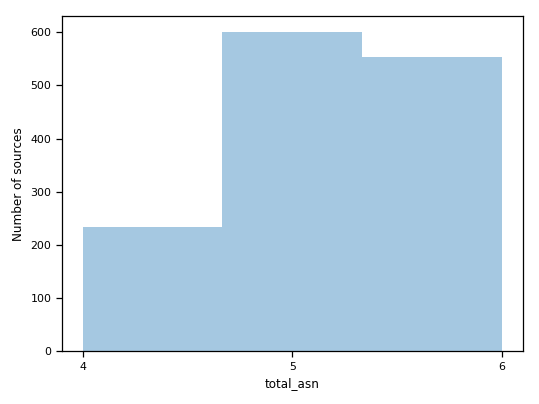

In [11]:
ig = plt.figure(figsize=(6,4.5))
ax = sns.distplot(good_asn_data['total_asn'] ,kde=False, bins=3)
#ax = sns.countplot(pr_data[param_best_name], color='steelblue')
#ax.set_yscale('log')
ax.set_ylabel('Number of sources')
plt.tight_layout()
ax.set_xticks([4,5,6])
#save_name = str('hist_'+param_best_name+'.pdf')
#plt.savefig(save_name, bbox_inches='tight')





# Can employ visualisation technique above to check mean coordinate

# Test to see if mean coordinates are working

In [ ]:
good_asn_data[0:6].show_in_notebook()

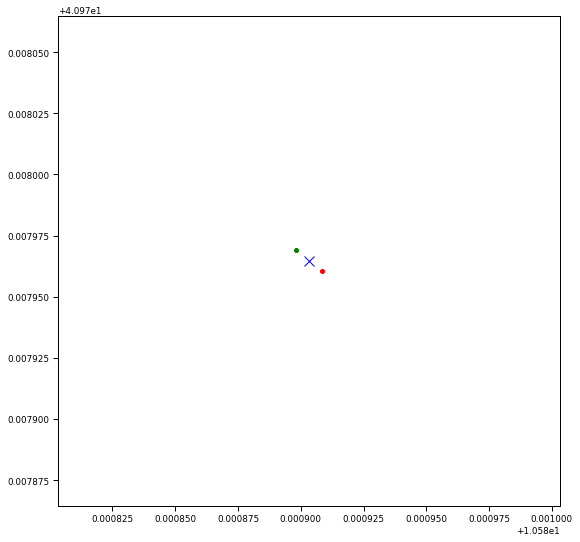

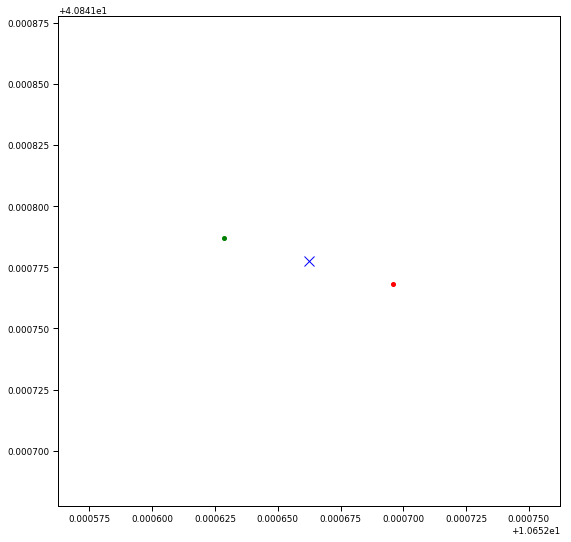

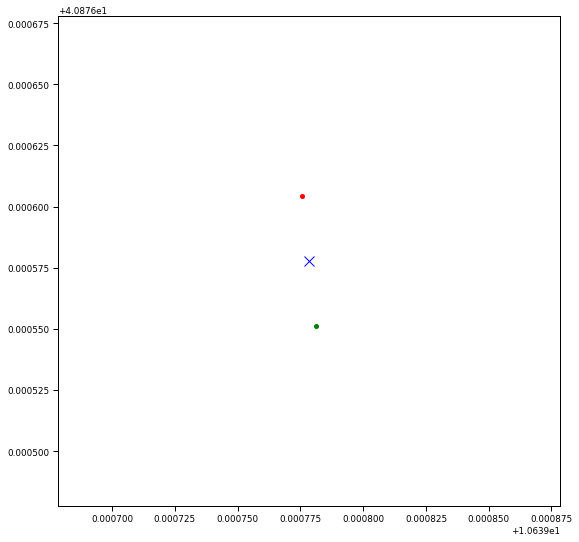

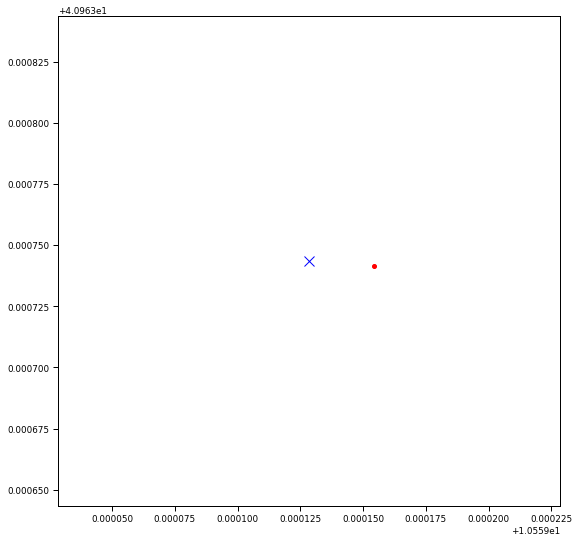

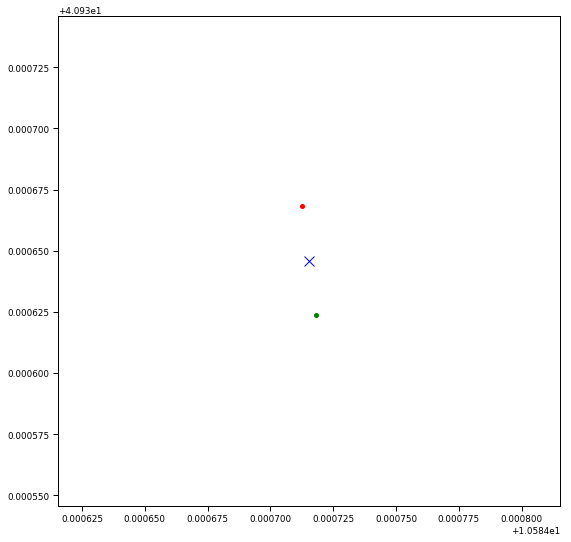

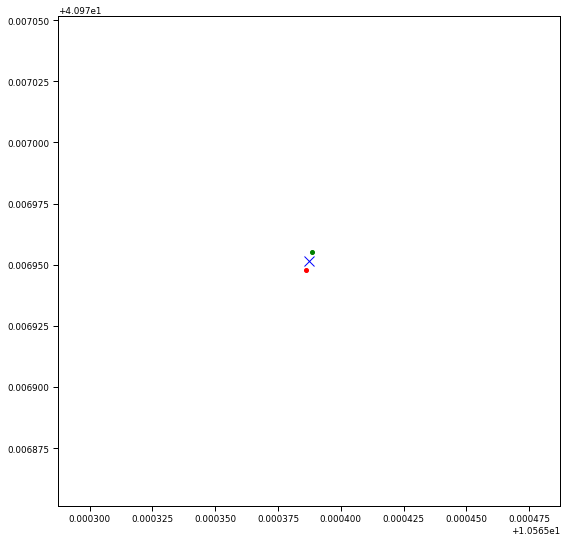

In [22]:
%matplotlib inline

# NB: This function assumes the 3rd coordinate is -99 (not used)
for i in range(6):
    plt.figure(figsize=(9,9))
    x1,y1 = good_asn_data['S2_F1_RA'][i],good_asn_data['S2_F1_DEC'][i]
    x2,y2 = good_asn_data['S2_F3_RA'][i],good_asn_data['S2_F3_DEC'][i]
    x3,y3 = good_asn_data['RA'][i],good_asn_data['DEC'][i]

    plt.plot(x1,y1,'ro',ms=4)
    plt.plot(x2,y2,'go',ms=4)
    plt.plot(x3,y3,'bx',ms=10)
    stretch = 0.0001
    plt.xlim(x3-stretch,x3+stretch)
    plt.ylim(y3-stretch,y3+stretch)